In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md
### change to reflect your notebook
_nb_loc = "05_create_dataset/05_audio_video_text.ipynb"
_nb_title = "Vision ML on Audio, Video, Text, etc."

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Vision+ML+on+Audio%2C+Video%2C+Text%2C+etc.&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F05_create_dataset%2F05_audio_video_text.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/05_create_dataset/05_audio_video_text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/05_create_dataset/05_audio_video_text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/05_create_dataset/05_audio_video_text.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# オーディオ、動画、テキストに関するコンピュータビジョン

このノートブックでは、様々なデータを機械学習モデルの画像入力として使用する方法を示します。
- オーディオファイルをスペクトログラムに変換する
- 動画からフレームを取得する、または移動平均により画像を構成する
- テキストを各文の埋め込みで構成された画像に変換する


## オーディオの変換

In [2]:
!gsutil cp gs://ml-design-patterns/audio_train/00353774.wav cello.wav
!gsutil cp gs://ml-design-patterns/audio_train/001ca53d.wav sax.wav

Copying gs://ml-design-patterns/audio_train/00353774.wav...
/ [1 files][389.4 KiB/389.4 KiB]                                                
Operation completed over 1 objects/389.4 KiB.                                    
Copying gs://ml-design-patterns/audio_train/001ca53d.wav...
/ [1 files][888.9 KiB/888.9 KiB]                                                
Operation completed over 1 objects/888.9 KiB.                                    


(129, 2031)
(129, 889)


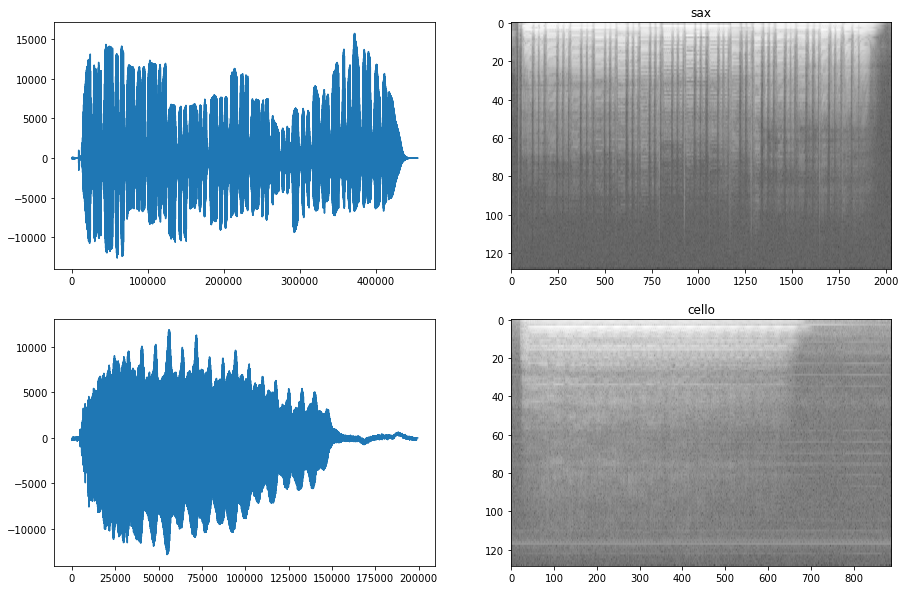

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for idx, instr in enumerate(['sax', 'cello']):
  sample_rate, samples = wavfile.read(instr + '.wav')
  ax[idx][0].plot(samples)
  _, _, spectro = signal.spectrogram(samples, sample_rate)
  img = np.log(spectro)
  ax[idx][1].imshow(img, cmap='gray', aspect='auto');
  ax[idx][1].set_title(instr)
  print(img.shape)

## 動画の変換

動画はフレームで構成され、各フレームは画像です。

In [4]:
!curl -O https://www.engr.colostate.edu/me/facil/dynamics/files/flame.avi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  282k  100  282k    0     0  1186k      0 --:--:-- --:--:-- --:--:-- 1186k


110


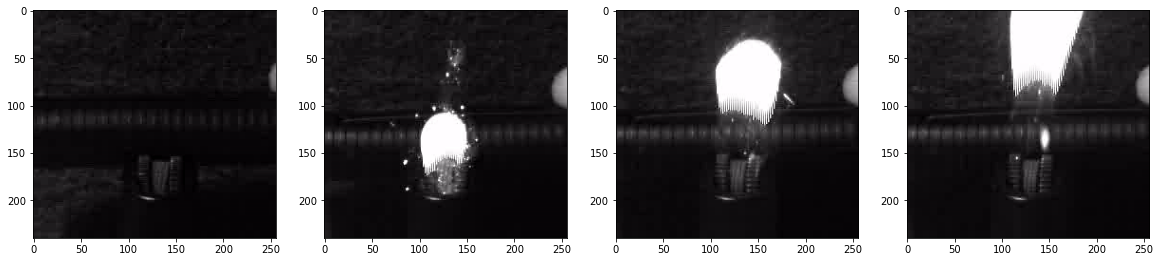

In [5]:
## Frame-by-frame
import cv2
import numpy as np
import matplotlib.pyplot as plt

cap = cv2.VideoCapture('flame.avi')
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(num_frames)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for i in range(num_frames):
  ret, frame = cap.read()
  if ret:
    img = np.asarray(frame)
    if i%30 == 0:
      ax[i//30].imshow(img)

また、各フレームの移動平均を取ることで画像を構成することも可能です。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


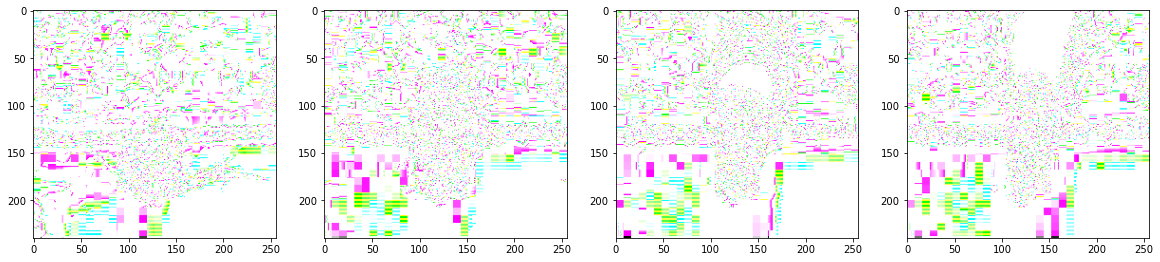

In [6]:
## Rolling average of 30 frames at a time
def rolling_average(cap, N):
  img = None;
  n = 0
  for i in range(N):
    ret, frame = cap.read()
    if ret:
      frame = np.asarray(frame)
      if n > 0:
        img = frame + img
      else:
        img = frame
      n += 1
  if n > 0:
    return img / n
  return img

cap = cv2.VideoCapture('flame.avi')
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
  img = rolling_average(cap, 25)
  ax[i].imshow(img)

In [7]:
# read into a 4D shape
import tensorflow as tf
def read_video(filename):
  cap = cv2.VideoCapture(filename)
  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frames = []
  for i in range(num_frames):
    ret, frame = cap.read()
    if ret:
      frames.append(np.asarray(frame))
  return tf.convert_to_tensor(frames)

img4d = read_video('flame.avi')
print(img4d.shape)

(110, 240, 256, 3)


2022-07-10 14:09:16.972914: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## テキストの変換

段落を文に分割し、文を埋め込みに変換し、各文の数値表現を獲得することができます。<br>
それにより、段落を画像にすることができます。

In [8]:
import tensorflow_hub as hub
paragraph = """
Siddhartha gave his clothes to a poor Brahmin on the road and
only retained his loincloth andearth-colored unstitched cloak.
He only ate once a day and never cooked food. He fasted fourteen
days. He fasted twenty-eight days. The flesh disappeared from
his legs and cheeks. Strange dreams were reflected in his enlarged
eyes. The nails grew long on his thin fingers and a dry, bristly
beard appeared on his chin. His glance became icy when he
encountered women; his lips curled with contempt when he passed
through a town of well-dressed people. He saw businessmen trading,
princes going to the hunt, mourners weeping over their dead,
prostitutes offering themselves, doctors attending the sick,
priests deciding the day for sowing, lovers making love, mothers
soothing their children -and all were not worth a passing glance,
everything lied, stank of lies; they were all illusions of sense,
happiness and beauty. All were doomed to decay. The world tasted
bitter. Life was pain.
"""

print(paragraph.split('.'))

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed(paragraph.split('.'))

['\nSiddhartha gave his clothes to a poor Brahmin on the road and\nonly retained his loincloth andearth-colored unstitched cloak', '\nHe only ate once a day and never cooked food', ' He fasted fourteen\ndays', ' He fasted twenty-eight days', ' The flesh disappeared from\nhis legs and cheeks', ' Strange dreams were reflected in his enlarged\neyes', ' The nails grew long on his thin fingers and a dry, bristly\nbeard appeared on his chin', ' His glance became icy when he\nencountered women; his lips curled with contempt when he passed\nthrough a town of well-dressed people', ' He saw businessmen trading,\nprinces going to the hunt, mourners weeping over their dead,\nprostitutes offering themselves, doctors attending the sick,\npriests deciding the day for sowing, lovers making love, mothers\nsoothing their children -and all were not worth a passing glance,\neverything lied, stank of lies; they were all illusions of sense,\nhappiness and beauty', ' All were doomed to decay', ' The world ta


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=8

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'

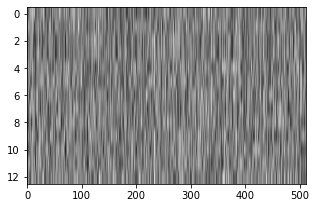

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,10))
plt.imshow(embeddings.numpy(), aspect=25.0, cmap='gray');

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.